In [1]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer, models, LoggingHandler, InputExample, losses, evaluation
from sentence_transformers.losses import SiameseDistanceMetric
import numpy as np
import random
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

VOC_NAMES = ["Alpha", "Beta", "Delta", "Gamma", "Omicron"]
LOSS_NAME = "SoftmaxLoss"
POOLING_MODE = "cls"

In [2]:
#word_embedding_model = models.Transformer(model_name_or_path="Rostlab/prot_bert", max_seq_length=1280)

encoder = models.Transformer(model_name_or_path="./mlm_checkpoints/CoV-RoBERTa_2048",
                                          max_seq_length=1280,
                                          tokenizer_name_or_path="tok/")

pooler = models.Pooling(encoder.get_word_embedding_dimension(), pooling_mode = POOLING_MODE)


model = SentenceTransformer(modules=[encoder, pooler])

Some weights of the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

# Load Dataset

In [3]:
sequences = []
for voc_name in VOC_NAMES:
    sequences.append(pd.read_csv(f"data/unique_{voc_name}_2k.csv")["sequence"].tolist())

# read a sequence from txt file
with open("data/wildtype.txt", "r") as file:
    wildtype = file.read()

# create dataframe using sequences
df = pd.DataFrame()
df["reference"] = [wildtype for _ in range(10000)]
df["sequence"] = [item for sublist in sequences for item in sublist]
df["label"] = [i for i in range(len(VOC_NAMES)) for _ in range(2000)]

# write to csv
df.to_csv("data/combined_with_wt_10k.csv", index=False)

eris_sequences = pd.read_csv("data/unique_Eris_2k.csv")["sequence"].tolist()

df_eris = pd.DataFrame()
df_eris["reference"] = [wildtype for _ in range(len(eris_sequences))]
df_eris["sequence"] = eris_sequences
df_eris["label"] = [5 for _ in range(len(eris_sequences))]

print(len(df))
print(len(df_eris))

10000
1623


In [4]:
# split the data into train, dev, and test stratified by label
from sklearn.model_selection import train_test_split

df_train, df_dev = train_test_split(df, test_size=0.2, random_state=seed, stratify=df["label"])
df_dev, df_test = train_test_split(df_dev, test_size=0.5, random_state=seed, stratify=df_dev["label"])

train_examples = []
for i, row in df_train.iterrows():
    train_examples.append(InputExample(texts=[row["reference"], row["sequence"]], label=row["label"]))

dev_examples = []
for i, row in df_dev.iterrows():
    dev_examples.append(InputExample(texts=[row["reference"], row["sequence"]], label=row["label"]))

# sample 400 rows from eris and concat to df_test
df_test = pd.concat([df_test, df_eris.sample(n=400, random_state=seed)])
# shuffle the dataframe
df_test = df_test.sample(frac=1, random_state=seed).reset_index(drop=True)

test_examples = []
for i, row in df_test.iterrows():
    test_examples.append(InputExample(texts=[row["reference"], row["sequence"]], label=row["label"]))

print(len(train_examples))
print(len(dev_examples))
print(len(test_examples))

8000
1000
1400


In [5]:
batch_size = 200
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
dev_dataloader = DataLoader(dev_examples, shuffle=False, batch_size=batch_size)
test_dataloader = DataLoader(test_examples, shuffle=False, batch_size=batch_size)

In [6]:
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=6)

Softmax loss: #Vectors concatenated: 3


In [7]:
evaluator = evaluation.LabelAccuracyEvaluator(dev_dataloader, softmax_model=train_loss, name="validation")

In [8]:
import os

# Create output directory if needed
output_dir = f"./{LOSS_NAME}_output_{POOLING_MODE}_zeroshot"
checkpoint_dir = f"{output_dir}/checkpoints"
evaluator_dir = f"{output_dir}/eval"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(evaluator_dir):
    os.makedirs(evaluator_dir)

# read loss values from csv:
train_results_file = os.path.join(output_dir, 'eval', 'training_results.csv')
val_results_file = os.path.join(output_dir, 'eval', 'validation_results.csv')

In [9]:
# Check if the file exists before attempting to delete
if os.path.exists(train_results_file):
    try:
        # Attempt to remove the file
        os.remove(train_results_file)
        print(f"File {train_results_file} deleted successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"File {train_results_file} does not exist.")

# Check if the file exists before attempting to delete
if os.path.exists(val_results_file):
    try:
        # Attempt to remove the file
        os.remove(val_results_file)
        print(f"File {val_results_file} deleted successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"File {val_results_file} does not exist.")


if os.path.exists(os.path.join(output_dir, 'eval', 'test_preds.csv')):
    try:
        # Attempt to remove the file
        os.remove(os.path.join(output_dir, 'eval', 'test_preds.csv'))
        print(f"File {os.path.join(output_dir, 'eval', 'test_preds.csv')} deleted successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"File {os.path.join(output_dir, 'eval', 'test_preds.csv')} does not exist.")

File ./SoftmaxLoss_output_cls_zeroshot/eval/training_results.csv deleted successfully.
File ./SoftmaxLoss_output_cls_zeroshot/eval/validation_results.csv deleted successfully.
File ./SoftmaxLoss_output_cls_zeroshot/eval/test_preds.csv deleted successfully.


In [10]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=30,
          optimizer_params= {'lr': 1e-3}, # 1e-3 for CoV-RoBERTa, 1e-6 for ProtBERT
          weight_decay=0.1, # 0.1 for CoV-RoBERTa, 0.01 for ProtBERT
          #evaluation_steps=eval_iter, # run an evalution in every 10% 
          output_path=output_dir,
          save_best_model=True,
          checkpoint_path=checkpoint_dir,
          checkpoint_save_steps=500,
          checkpoint_save_total_limit=2,
          show_progress_bar=True,
          loss_name=LOSS_NAME)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 0 ---
Train Loss = 1.5586   Train Accuracy = 37.0000
Valid Loss = 0.01   Valid Accuracy = 37.20


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 1 ---
Train Loss = 1.2594   Train Accuracy = 49.0000
Valid Loss = 0.01   Valid Accuracy = 52.70


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 2 ---
Train Loss = 0.7848   Train Accuracy = 71.5000
Valid Loss = 0.00   Valid Accuracy = 72.50


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 3 ---
Train Loss = 0.4654   Train Accuracy = 82.0000
Valid Loss = 0.00   Valid Accuracy = 85.10


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 4 ---
Train Loss = 0.2239   Train Accuracy = 92.5000
Valid Loss = 0.00   Valid Accuracy = 90.80


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 5 ---
Train Loss = 0.0926   Train Accuracy = 97.0000
Valid Loss = 0.00   Valid Accuracy = 92.00


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 6 ---
Train Loss = 0.0327   Train Accuracy = 99.0000
Valid Loss = 0.00   Valid Accuracy = 95.70


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 7 ---
Train Loss = 0.0304   Train Accuracy = 99.0000
Valid Loss = 0.00   Valid Accuracy = 95.30


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 8 ---
Train Loss = 0.0139   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 96.10


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 9 ---
Train Loss = 0.0044   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.00


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 10 ---
Train Loss = 0.0039   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.70


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 11 ---
Train Loss = 0.0051   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 98.20


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 12 ---
Train Loss = 0.0011   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.30


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 13 ---
Train Loss = 0.0009   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.70


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 14 ---
Train Loss = 0.0306   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 97.60


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 15 ---
Train Loss = 0.0237   Train Accuracy = 99.0000
Valid Loss = 0.00   Valid Accuracy = 97.30


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 16 ---
Train Loss = 0.0187   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 97.60


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 17 ---
Train Loss = 0.0009   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.70


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 18 ---
Train Loss = 0.0270   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 97.40


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 19 ---
Train Loss = 0.0043   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 97.90


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 20 ---
Train Loss = 0.0008   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 98.20


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 21 ---
Train Loss = 0.0001   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 98.10


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 22 ---
Train Loss = 0.0002   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 98.30


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 23 ---
Train Loss = 0.0002   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.10


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 24 ---
Train Loss = 0.0019   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.90


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 25 ---
Train Loss = 0.0001   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 98.80


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 26 ---
Train Loss = 0.0228   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 98.00


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 27 ---
Train Loss = 0.0007   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 98.20


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 28 ---
Train Loss = 0.0001   Train Accuracy = 100.0000
Valid Loss = 0.00   Valid Accuracy = 97.60


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

--- Epoch 29 ---
Train Loss = 0.0254   Train Accuracy = 99.5000
Valid Loss = 0.00   Valid Accuracy = 98.20


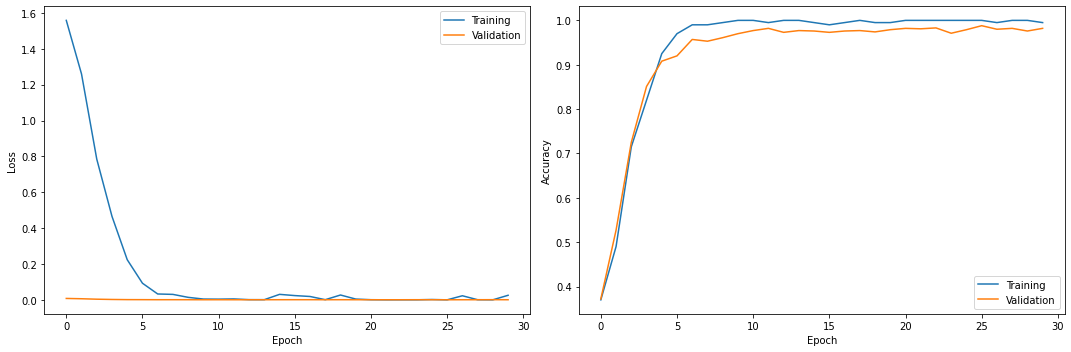

In [11]:
# Plot the training and validation loss and accuracy
import matplotlib.pyplot as plt

# read loss values from csv:
train_results = pd.read_csv(train_results_file)
val_results = pd.read_csv(val_results_file)

# plot loss and accuracy figures side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_results["epoch"], train_results["loss"], label="Training")
axs[0].plot(val_results["epoch"], val_results["loss"], label="Validation")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(train_results["epoch"], train_results["accuracy"], label="Training")
axs[1].plot(val_results["epoch"], val_results["accuracy"], label="Validation")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
plt.tight_layout()
#save as pdf
plt.savefig(os.path.join(output_dir, "eval", f'plot_{LOSS_NAME}_{POOLING_MODE}.pdf'))
plt.show()

In [12]:
test_evaluator = evaluation.LabelAccuracyEvaluator(test_dataloader, softmax_model=train_loss, name="test")

# load best model
best_model = SentenceTransformer(output_dir)
best_model.to("cuda")

# print test duration

import time
start_time = time.time()
test_acc = best_model.evaluate(test_evaluator, output_path=os.path.join(output_dir, "eval"))
duration = time.time() - start_time
print(f"Test duration: {duration} seconds")

# write test accuracy to file
with open(os.path.join(output_dir, "eval", "test_results.txt"), "w") as f:
    f.write(f"Test accuracy: {test_acc}\n")

print(duration * 1000 / len(test_examples), "ms per example")

Valid Loss = 0.01   Valid Accuracy = 70.14
Test duration: 0.3177635669708252 seconds
0.2269739764077323 ms per example
